In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

In [2]:
df_wq = pd.read_csv('waterquality.csv')
print(df_wq.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371 entries, 0 to 2370
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    2366 non-null   object 
 1   Salinity (ppt)          2241 non-null   float64
 2   DissolvedOxygen (mg/L)  1520 non-null   float64
 3   pH                      2276 non-null   float64
 4   SecchiDepth (m)         2298 non-null   float64
 5   WaterDepth (m)          2300 non-null   float64
 6   WaterTemp (C)           2250 non-null   float64
 7   AirTemp (C)             2371 non-null   float64
dtypes: float64(7), object(1)
memory usage: 148.3+ KB
None


In [3]:
df_wq = df_wq.dropna(subset = 'Date')
df_wq['Date'] = pd.to_datetime(df_wq['Date'], format = '%Y-%m-%d')
df_wq['Year'] = df_wq['Date'].dt.year

df_wq_f = pd.DataFrame()
for i in list(df_wq['Year'].unique()):
    df = df_wq[df_wq['Year'] == i]
    df['Salinity (ppt)'] = df['Salinity (ppt)'].fillna(method = 'bfill')
    df['DissolvedOxygen (mg/L)'] = df['DissolvedOxygen (mg/L)'].fillna(method = 'bfill')
    df['pH'] = df['pH'].fillna(method = 'bfill')
    df['SecchiDepth (m)'] = df['SecchiDepth (m)'].fillna(method = 'bfill')
    df['WaterDepth (m)'] = df['WaterDepth (m)'].fillna(method = 'bfill')
    df['WaterTemp (C)'] = df['WaterTemp (C)'].fillna(method = 'bfill')
    df['AirTemp (C)'] = df['AirTemp (C)'].fillna(method = 'bfill')
    df_wq_f = pd.concat([df_wq_f,df], axis = 0)

df_wq_f2 = pd.DataFrame()
for i in list(df_wq_f['Year'].unique()):
    df = df_wq_f[df_wq_f['Year'] == i]
    df['Salinity (ppt)'] = df['Salinity (ppt)'].fillna(method = 'ffill')
    df['DissolvedOxygen (mg/L)'] = df['DissolvedOxygen (mg/L)'].fillna(method = 'ffill')
    df['pH'] = df['pH'].fillna(method = 'ffill')
    df['SecchiDepth (m)'] = df['SecchiDepth (m)'].fillna(method = 'ffill')
    df['WaterDepth (m)'] = df['WaterDepth (m)'].fillna(method = 'ffill')
    df['WaterTemp (C)'] = df['WaterTemp (C)'].fillna(method = 'ffill')
    df['AirTemp (C)'] = df['AirTemp (C)'].fillna(method = 'ffill')
    df_wq_f2 = pd.concat([df_wq_f2,df], axis = 0)

df_wq_f2 = df_wq_f2.fillna(method = 'bfill')
df_wq_f2 = df_wq_f2.reset_index(drop = True)

df_wq_final = df_wq_f2.copy()
df_wq_final = df_wq_final.drop(columns = ['Year','Date'], axis = 1)
df_wq_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366 entries, 0 to 2365
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Salinity (ppt)          2366 non-null   float64
 1   DissolvedOxygen (mg/L)  2366 non-null   float64
 2   pH                      2366 non-null   float64
 3   SecchiDepth (m)         2366 non-null   float64
 4   WaterDepth (m)          2366 non-null   float64
 5   WaterTemp (C)           2366 non-null   float64
 6   AirTemp (C)             2366 non-null   float64
dtypes: float64(7)
memory usage: 129.5 KB


# Extracción de las Características más Relevantes mediante PCA

In [4]:
# Estandariza los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_wq_final)

# Aplicar PCA
pca = PCA(n_components=7)
principal_components = pca.fit_transform(df_scaled)

# Crear un DataFrame con los componentes principales
pca_df = pd.DataFrame(data=principal_components, columns=df_wq_final.columns)

# Varianza explicada por cada componente
print(pca.explained_variance_ratio_)

# Base para el KMeans (para fines gráficos, se seleccionan 3 características principales)
pca_df = pca_df.iloc[:,:3]
print(pca_df)

[0.30207567 0.27402422 0.1805707  0.10006548 0.07801437 0.03861983
 0.02662973]
      Salinity (ppt)  DissolvedOxygen (mg/L)         pH
0           2.659285               -1.592684   0.650650
1           0.427176               -1.351027   0.880439
2          -0.191177               -0.832492   1.534447
3          -0.546270               -0.603831   1.656738
4          -2.769783                0.476843   0.515465
...              ...                     ...        ...
2361       -0.090613                0.280208  -0.177436
2362       -0.019623                1.368311  -0.676393
2363       -0.660535               -0.270882  -1.539942
2364        0.784266                0.775918  -0.895245
2365        7.310352               22.244489  10.370269

[2366 rows x 3 columns]


# Armado del Modelo KMeans

## Selección del Número de Clusters

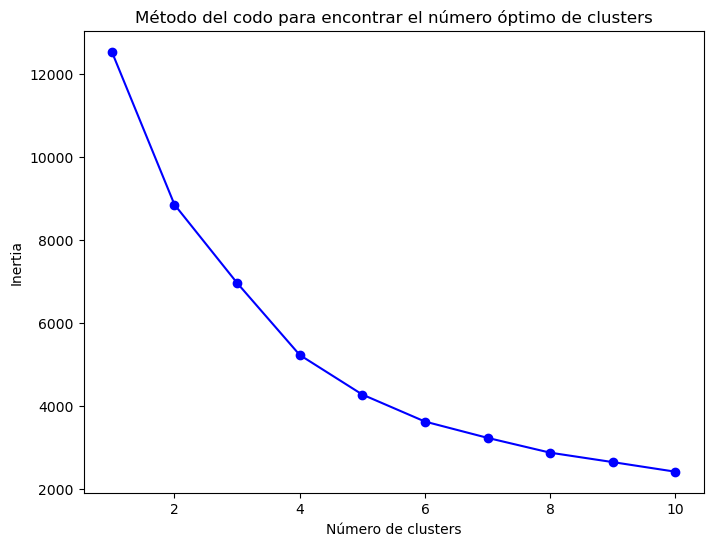

In [5]:
# Método del codo
def elbow_method(df):
    inertia = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inertia')
    plt.title('Método del codo para encontrar el número óptimo de clusters')
    plt.show()

elbow_method(pca_df)

## Armado del Modelo

In [7]:
# Inicializar el modelo K-means
kmeans = KMeans(n_clusters=4, random_state=42)

# Ajustar el modelo a los datos
kmeans.fit(pca_df)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Agregar las etiquetas de los clusters al dataframe original
pca_df['Cluster'] = labels

df = px.data.iris()
fig = px.scatter_3d(pca_df, x='Salinity (ppt)', y='DissolvedOxygen (mg/L)', z='pH',
              color='Cluster', size_max = 30, template = 'plotly_dark')
fig.show()